In [1]:
import time
import os
import random
import math

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import transforms, models
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
# from sklearn.model_selection import KFold
# from tqdm.auto import tqdm
from scipy import ndimage
import pickle
import logging
import torchvision.models as models
%matplotlib inline

In [ ]:
x = torch.tensor([1e-7, 1e-7])

In [ ]:
torch.div(torch.tensor([1, 1]),x)

tensor([10000000., 10000000.])

In [2]:
assert os.environ['COLAB_GPU'], 'Make sure to select GPU from Edit > Notebook settings > Hardware accelerator'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -f data
!ln -s '/content/drive/MyDrive/proj2_data' data

##some utility

In [4]:
def collate_fn1(batch):
    return tuple(zip(*batch))

def imshow(img, gt_box, turb_type,pred_box=None):
    plt.imshow(img)
    
    def draw_box(box, turb_type):
        x, y, w, h = box
        if x == 0:
            x = 1
        if y == 0:
            y = 1
        if turb_type=='turbulence':
          color='red'
        else:
          color='green'
        plt.gca().add_patch(
            plt.Rectangle((x, y), w-x, h-y,
                          fill=False, edgecolor=color, linewidth=2, alpha=0.5)
        )
    for i in range(len(box)):
      draw_box(box[i],turb_type[i])
    if pred_box is not None:
        draw_box(pred_box, 'blue')
    plt.plot()

def to_2d_tensor(inp):
    inp = torch.Tensor(inp)
    if len(inp.size()) < 2:
        inp = inp.unsqueeze(0)
    return inp

def box_transform_inv(boxes, im_sizes):
    # box in (x, y, w, h) format
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes[:, 0] = (boxes[:, 0] + 1) / 2 * im_sizes[:, 0]
    boxes[:, 1] = (boxes[:, 1] + 1) / 2 * im_sizes[:, 1]
    boxes[:, 2] = boxes[:, 2] / 2 * im_sizes[:, 0]
    boxes[:, 3] = boxes[:, 3] / 2 * im_sizes[:, 1]
    return boxes

def box_transform(boxes, im_sizes):
    # box in (x, y, w, h) format
    boxes = to_2d_tensor(boxes)
    im_sizes = to_2d_tensor(im_sizes)
    boxes[:, 0] = 2 * boxes[:, 0] / im_sizes[:, 0] - 1
    boxes[:, 1] = 2 * boxes[:, 1] / im_sizes[:, 1] - 1
    boxes[:, 2] = 2 * boxes[:, 2] / im_sizes[:, 0]
    boxes[:, 3] = 2 * boxes[:, 3] / im_sizes[:, 1]
    return boxes

def xywh_to_x1y1x2y2(boxes):
    boxes = to_2d_tensor(boxes)
    boxes[:, 2] += boxes[:, 0] - 1
    boxes[:, 3] += boxes[:, 1] - 1
    return boxes

def x1y1x2y2_to_xywh(boxes):
    boxes = to_2d_tensor(boxes)
    boxes[:, 2] -= boxes[:, 0] - 1
    boxes[:, 3] -= boxes[:, 1] - 1
    return boxes

def compute_IoU(boxes1, boxes2):
    boxes1 = to_2d_tensor(boxes1)
    boxes2 = to_2d_tensor(boxes2)

    
    intersec = boxes1.clone()
    intersec[:, 0] = torch.max(boxes1[:, 0], boxes2[:, 0])
    intersec[:, 1] = torch.max(boxes1[:, 1], boxes2[:, 1])
    intersec[:, 2] = torch.min(boxes1[:, 2], boxes2[:, 2])
    intersec[:, 3] = torch.min(boxes1[:, 3], boxes2[:, 3])
    
    def compute_area(boxes):
        # in (x1, y1, x2, y2) format
        dx = boxes[:, 2] - boxes[:, 0]
        dx[dx < 0] = 0
        dy = boxes[:, 3] - boxes[:, 1]
        dy[dy < 0] = 0
        return dx * dy
    
    a1 = compute_area(boxes1)
    a2 = compute_area(boxes2)
    ia = compute_area(intersec)
    assert((a1 + a2 - ia <= 0).sum() == 0)
    
    return ia / (a1 + a2 - ia)    

def compute_acc(preds, targets, theta=0.75):
    IoU = compute_IoU(preds.clone(), targets.clone())
    corr = (IoU >= theta).sum()
    return corr.item() / preds.size(0)

class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        
def box_to_mask(box, im_size):
    mask = np.zeros(im_size)
    co = xywh_to_x1y1x2y2(box)[0].type(torch.int64)
    mask[co[0]: co[2], co[1]: co[3]] = 1
    return Image.fromarray(np.uint8(mask*255).T)

def mask_to_box(mask):
    mask = torch.nonzero(mask[0, :, :].T != 0, as_tuple=False)
    x1, y1 = torch.min(mask, dim=0).values
    x2, y2 = torch.max(mask, dim=0).values
    return x1y1x2y2_to_xywh([x1, y1, x2, y2])[0]

#### ROI_PROPOSAL_ALGORITHM
def extractImgbyRoI(img, Coords):
  (x_min, y_min, x_max, y_max) = Coords[0]
  result = img[:, y_min:y_max, x_min:x_max]
  for i in range(1, len(Coords)):
    (x_min, y_min, x_max, y_max) = Coords[i]
    result = np.concatenate((result, img[:, y_min:y_max, x_min:x_max]), axis=2)
  return np.array(result)

def myImgShow(img):
  img = img.transpose((1, 2, 0))/255
  #img = img.numpy().transpose((1, 2, 0))/255
  plt.imshow(img)

def constructNeighbourGrid():
  size = 10
  neighbourGrid = []
 
  for i in range(size):
    for j in range(size):
      background = np.zeros((10, 10))
      #background[i][j] = 1
      # Dilation
      if i-1 >= 0: background[i-1][j] = 1
      if i+1 < size: background[i+1][j] = 1
      if j-1 >= 0: background[i][j-1] = 1
      if j+1 < size: background[i][j+1] = 1

      background = background.flatten()
      neighbourGrid.append(background == 1)

  return np.array(neighbourGrid)

def initCoord(img, size):
  _, h, w = img.shape
  sub_h, sub_w = math.floor(h/size), math.floor(w/size)
  RoIs = np.array([[[j*sub_w, i*sub_h, (j+1)*sub_w-1, (i+1)*sub_h-1] for j in range(size)] for i in range(size)])
  RoIs = RoIs.reshape(size*size, 4)
  return RoIs
    

def initRegions(size):
  return set([(i) for i in range(size)])


def regionsToCoord(Coords, regions):
  regions_list = tuple2list(regions)
  res = Coords[regions_list[0]].reshape(1, 4)
  for i in range(1, len(regions_list)):
    res = np.concatenate((res, Coords[regions_list[i]].reshape((1, 4))))
  return res


def regionsToCoord_test(Coords, regions):
  print(regions)
  regions_list = tuple2list(regions)
  print(regions_list[0])
  print(Coords[regions_list[0]].reshape(1, 4))
  res = Coords[regions_list[0]].reshape(1, 4)
  for i in range(1, len(regions_list)):
    res = np.concatenate((res, Coords[regions_list[i]].reshape((1, 4))))
  return res


def getHist(img):
  D, _, _ = img.shape
  histogram = []
  for channel_idx in range(D):
    h, _ = np.histogram(img[channel_idx, :, :], bins=25)
    histogram = histogram + list(h)
  histogram = np.array(histogram/np.linalg.norm(histogram, 1))
  return histogram

def sim(region1, region2):
  histogram1 = getHist(region1)
  histogram2 = getHist(region2)

  sim = np.vstack((histogram1, histogram2))
  sim = np.amin(sim, 0)
  sim = sim.sum()

  return sim

def findNeighbour(regions, size):
  neighbourGrid = np.zeros((size*size, 1))
  neighbourGrid[tuple2list(regions)] = 1
  neighbourGrid = neighbourGrid.reshape((size, size))
  neighbourGrid = ndimage.binary_dilation(neighbourGrid).astype(neighbourGrid.dtype)
  neighbourGrid = neighbourGrid.reshape((size*size, 1))
  neighbourGrid[tuple2list(regions)] = 0
  return np.where(neighbourGrid == 1)[0]

def tuple2list(input):
  if type(input) == int:
    return [input]
  res = []
  for element in input:
    if type(element) == tuple:
      res = res + list(element)
    else:
      res.append(element)
  return res

def removeEnclosedRegion(regions, newR):
  redundance = set()
  for t in regions:
    if set(t).issubset(newR):
      redundance.add(t)

  regions.symmetric_difference_update(redundance)
  return regions

def cropRect(RoIs, regions):
  res = RoIs
  for region in regions:
    coords = regionsToCoord(RoIs, region)

    coord_max = np.amax(coords, axis=0)
    coord_min = np.amin(coords, axis=0)

    vector = [coord_min[0], coord_min[1], coord_max[2], coord_max[3]]
    res = np.vstack((res, vector))

  return np.array(res)




In [ ]:
def genRoIsperImg(im, size): 
  RoIs = initCoord(im, size)
  regions = initRegions(size*size)

  neighbourGrid = constructNeighbourGrid()

  simGrid = set()
  for i in range(size*size):
    for j in range(i, size*size):
      if neighbourGrid[i][j]:
        img1 = extractImgbyRoI(im, regionsToCoord(RoIs, [i]))
        img2 = extractImgbyRoI(im, regionsToCoord(RoIs, [j]))
        simGrid.add((i, j, sim(img1, img2)))

  regions_merged = set()
  current_merged_regions = set()
  i = 0
  while len(simGrid) > 0:
  #for i in range(20):
    # print('itr#:', i, " with size= ", len(simGrid))
    i = i+1
    region1, region2, _ = max(simGrid, key=lambda x:x[2])
    #print("region1 = ", region1)
    #print("region2 = ", region2)
    newRegion = set()
    newRegion.update(tuple2list(region1))
    newRegion.update(tuple2list(region2))
    regions_merged.add(tuple(newRegion))
    current_merged_regions = removeEnclosedRegion(current_merged_regions, tuple(newRegion))
    current_merged_regions.add(tuple(newRegion))
    removeList = list(filter(lambda x: x[0] == region1 or x[1] == region1, simGrid))
    #print("remove one = ", removeList)
    c1 = len(removeList)
    simGrid.difference_update(removeList)
    removeList = list(filter(lambda x: x[0] == region2 or x[1] == region2, simGrid))
    #print("remove two = ", removeList)
    c1 = c1 + len(removeList)
    #print("no of removal = ", c1)
    simGrid.difference_update(removeList)

    neighbourRegions = findNeighbour(newRegion, 10)
    #print("neigbour regions = ", neighbourRegions)
    for j in range(len(neighbourRegions)):
      neighbourRegion = neighbourRegions[j]
      #print("==== current neibh = ", neighbourRegion)
      counted = False
      for region in filter(lambda x: neighbourRegion in x, current_merged_regions):
        #print("region = ", region)
        counted = True
        img1 = extractImgbyRoI(im, regionsToCoord(RoIs, newRegion))
        img2 = extractImgbyRoI(im, regionsToCoord(RoIs, region))
        #print("add: ", (tuple(newRegion), region, sim(img1, img2)))
        simGrid.add((tuple(newRegion), region, sim(img1, img2)))

      if counted:
        #print(neighbourRegion, ' is counted')
        continue

      for region in filter(lambda x:x==neighbourRegion, regions):
        #print("single region = ", region)
        img1 = extractImgbyRoI(im, regionsToCoord(RoIs, newRegion))
        img2 = extractImgbyRoI(im, regionsToCoord(RoIs, [region]))
        #print("add: ", (tuple(newRegion), region, sim(img1, img2)))
        simGrid.add((tuple(newRegion), region, sim(img1, img2)))

    if len(simGrid) <= 0:
      break
  
  res = cropRect(RoIs, regions_merged)
  res = set([tuple(ele) for ele in res])
  res = np.array(list(res))
  # print("finish")
  return res
    #print(regions_merged)
    #print(len(simGrid))

## define dataset

In [5]:
class MyDataset(Dataset):
    def __init__(self, datatype='train', transform=None):
        with open('data/bbox_'+datatype+'.csv') as f:
            id_to_box = dict()
            id_to_path = dict()
            id_to_turb= dict()
            last_name='none'
            idx=-1
            for line in f.read().splitlines():
                filename, wid, hei, turb, *box = line.split(',') # get all variable
                if turb =='severe turbulence':
                  turb_no=2
                else:
                  turb_no=1
                if filename == 'filename': # skip the title
                  continue

                if filename==last_name:
                  id_to_box[idx].append(list(map(float, box)))
                  id_to_turb[idx].append(turb_no)
                  
                else:
                  idx=idx+1
                  id_to_path[idx]=filename
                  id_to_box[idx]=[list(map(float, box))]
                  id_to_turb[idx]=[turb_no]
                  last_name=filename

            self.imgs = [(os.path.join('data/'+datatype, id_to_path[i]), id_to_box[i],id_to_turb[i])
                     for i in range(len(id_to_path))]

            #transform data
            self.target_transform = transforms.Compose([
                transforms.Resize((840, 840)),
                transforms.ToTensor()
            ])
            self.transform = transforms.Compose([
                self.target_transform,
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            if transform is not None:
                self.transform = transforms.Compose([
                    transform,
                    self.transform
                ])
                self.target_transform = transforms.Compose([
                    transform,
                    self.target_transform
                ])
                
    #Added by Shih-Yang,LIU
    #This prepare function calculate and store all the data needed for each image
    # data includes image itself, ground truth roi, ground truth class labels and proposed rois of each image
    # each element inside rois list is a tuple with first element being the coordinate of this roi in the foramte of (x1,y1,x2,y2)
    # Second element within the tuple is a dictionary that store the information of this specific RoI
    #{
    #  roi_dict = {
    #          "gt_box_iou_score": most_likely_gt_box_iou_score, ==> the iou score 
    #          "gt_index": most_likely_gt_index,
    #          "gt_box_coord": gt_box_coord,
    #          "gt_box_coord_xywh": gt_box_coord_xywh,
    #          "gt_box_class": gt_box_class
    #      }
    #}
    def prepare_data(self):
      

      self.data = []
      img_count = 1
      for img in self.imgs:
        # if img_count == 5:
        #   break
        print("processing image#: ", img_count)
        img_count = img_count+1
        path, box, turb = img
        im = (np.load(path))/292*255
        im=np.transpose(im,(1, 2, 0))
        im=np.uint8(im)
        boxes = np.array(box, dtype='int32')
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        PIL = transforms.ToPILImage()(im).convert('RGB')#if you want to output 4 dimension data, change to .convert('RGBA'). While you will not able to do transforms.Normalize()
        im = self.transform(PIL)

        v = genRoIsperImg(im, 10)


        proposed_roi_lable = []
        for i in v:
          IoU_list = []
          for gt_box in box:
            IoU = compute_IoU(i, gt_box)
            IoU_list.append(IoU)
          most_likely_gt_box_iou_score = max(IoU_list)
          most_likely_gt_index = IoU_list.index(most_likely_gt_box_iou_score)
          gt_box_coord = box[most_likely_gt_index]
          if most_likely_gt_box_iou_score > 0:
            gt_box_class = turb[most_likely_gt_index]
          else:
            gt_box_class = 0

          gt_box_coord_xywh = np.array([gt_box_coord[0],gt_box_coord[1],gt_box_coord[2]-gt_box_coord[0],gt_box_coord[3]-gt_box_coord[1]])
          if(gt_box_coord_xywh[2]==0):
            print(gt_box_coord)



          roi_dict = {
              "gt_box_iou_score": most_likely_gt_box_iou_score,
              "gt_index": most_likely_gt_index,
              "gt_box_coord": gt_box_coord,
              "gt_box_coord_xywh": gt_box_coord_xywh,
              "gt_box_class": gt_box_class
          }

          proposed_roi_lable.append([i,roi_dict])

        self.data.append([im, box, turb, proposed_roi_lable])

          # print(most_likely_gt_box_iou_score, most_likely_gt_index, gt_box_coord, gt_box_class)




    def __getitem__(self, index):
      return self.data[index]

    def __len__(self):
        return len(self.imgs)

In [ ]:
# val=MyDataset(datatype='val', transform=None)
# val.prepare_data()
# torch.save(val,'/content/data/val.pt')

In [ ]:
# test=MyDataset(datatype='test', transform=None)
# test.prepare_data()
# torch.save(train,'/content/data/test.pt')

In [7]:
train = torch.load('/content/data/train.pt')
val = torch.load('/content/data/val.pt')

In [ ]:
test = torch.load('/content/data/test.pt')

In [8]:
train_dataloader = torch.utils.data.DataLoader(train,batch_size=2,shuffle=False,collate_fn=collate_fn1)
val_dataloader = torch.utils.data.DataLoader(val,batch_size=2,shuffle=False,collate_fn=collate_fn1)

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test,batch_size=2,shuffle=False,collate_fn=collate_fn1)

In [ ]:
np.NaN

nan

## minibatch sampling

In [10]:
# False -> Use old sampling method
# True -> Use new sampling method
def mini_batch_sampling(rois, size, portion, new=False):
  res = []
  if new:
    for roi in rois:
      # Extract ious scoure from dictionary
      roi = np.array(roi, dtype=object)
      dictionaries = roi[:, 1]
      ious = list(map(lambda x:x.get('gt_box_iou_score').item(), dictionaries))
      ious = np.array(ious)

      # Find the locaiton grid for postive label and negative label
      posLocation = (ious >= 0.5).astype(int)
      negLocation = ((ious >= 0.1)*(ious < 0.5)).astype(int)

      # Calculate the 
      posCount = np.sum(posLocation)
      no_of_pos_needed = math.floor(posCount*portion) if posCount*portion <= size else size
      no_of_neg_needed = size - no_of_pos_needed

      outputIdx = []

      # Extract pos index
      if no_of_pos_needed > 0:
        temp_ious = ious.copy()
        temp_ious[(1-posLocation).astype(bool)] = -1
        pos_idx = np.argpartition(temp_ious, -no_of_pos_needed)[-no_of_pos_needed:]
        #print(pos_idx)
        outputIdx = outputIdx + list(pos_idx)
      
      if no_of_neg_needed > 0:
        ious[(1-negLocation).astype(bool)] = -1
        neg_idx = np.argpartition(ious, -no_of_neg_needed)[-no_of_neg_needed:]
        outputIdx = outputIdx + list(neg_idx)

      res.append(outputIdx)
  else:
    for roi in rois:
      # Extract ious scoure from dictionary
      roi = np.array(roi, dtype=object)
      dictionaries = roi[:, 1]
      ious = list(map(lambda x:x.get('gt_box_iou_score').item(), dictionaries))
      ious = np.array(ious)

      #print(ious)

      # Find the locaiton grid for postive label and negative label
      posLocation = (ious >= 0.5).astype(int)
      negLocation = ((ious >= 0.1)*(ious < 0.5)).astype(int)

      # Calculate the 
      posCount = np.sum(posLocation)
      #print("cosCount = ", posCount)
      no_of_pos_needed = math.floor(posCount*portion) if posCount*portion <= size else size
      no_of_neg_needed = size - no_of_pos_needed


      
      outputIdx = []

      # Extract pos index
      pos_idx = np.where(posLocation == 1)[0]
      #print(pos_idx)
      outputIdx = outputIdx + list(pos_idx[0:no_of_pos_needed])


      if no_of_neg_needed > 0:
        ious[(1-negLocation).astype(bool)] = -1
        neg_idx = np.argpartition(ious, -no_of_neg_needed)[-no_of_neg_needed:]
        outputIdx = outputIdx + list(neg_idx)

      #print("negative and positive output = ", len(outputIdx))
      res.append(outputIdx)
  return res

## Fast R CNN Model

In [11]:
def _smooth_l1_loss(x, t, in_weight, sigma):

    sigma2 = sigma ** 2
    diff = in_weight * (x - t)
    abs_diff = diff.abs()
    flag = (abs_diff.data < (1. / sigma2)).float()
    y = (flag * (sigma2 / 2.) * (diff ** 2) +
         (1 - flag) * (abs_diff - 0.5 / sigma2))
    return y.sum()

In [12]:
def fast_rcnn_loc_loss(pred_loc, gt_loc, gt_label, sigma):
    in_weight = torch.zeros(gt_loc.shape).cuda()
    # Localization loss is calculated only for positive rois.
    # NOTE:  unlike origin implementation, 
    # we don't need inside_weight and outside_weight, they can calculate by gt_label
    in_weight[(gt_label > 0).view(-1, 1).expand_as(in_weight).cuda()] = 1
    loc_loss = _smooth_l1_loss(pred_loc, gt_loc, in_weight.detach(), sigma)
    # # Normalize by total number of negtive and positive rois.
    loc_loss /= ((gt_label >= 0).sum().float()) # ignore gt_label==-1 for rpn_loss
    return loc_loss

In [13]:
def normal_init(m, mean, stddev, truncated=False):
    """
    weight initalizer: truncated normal and random normal.
    """
    # x is a parameter
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
    else:
        m.weight.data.normal_(mean, stddev)
        m.bias.data.zero_()

In [15]:
class Fast_R_cnn(nn.Module):
  def __init__(self, roi_size, scaling_factor, rois_per_image,pretrained=True):
    super(Fast_R_cnn, self).__init__()
    self.roi_size = roi_size
    self.scaling_factor = scaling_factor
    alexnet = models.alexnet(pretrained=pretrained)
    #structure of alexnet could be modified if performance is bad
    self.alexnet = nn.Sequential(*list(alexnet.children())[:-2])
    self.alexnet[0][12]=nn.Identity() 

    self.ROI_pooling_layer = torchvision.ops.roi_pool
    self.rois_per_image = rois_per_image


    ## FCs to produced ROI feature vectors
    self.ROI_head = nn.Sequential(
      nn.Linear(in_features=43264, out_features=21632, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=21632, out_features=10816, bias=True),
      nn.ReLU(inplace=True),
      # nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=10816, out_features=3000, bias=True)
      # nn.ReLU(inplace=True),
      # nn.Dropout(p=0.5, inplace=False),
      # nn.Linear(in_features=5000, out_features=5000, bias=True),
      # nn.ReLU(inplace=True),
      # nn.Linear(in_features=5000, out_features=3000, bias=True)
    )

    n_class = 2
    ## FCs for softmax 
    self.classficiation_label = nn.Sequential(
      nn.Linear(3000, 3), #Because 3 classes
      nn.Softmax()
    )

    ## FCs for bbox regressor 
    self.fc_before_regressor = nn.Sequential(
      nn.Linear(3000, 4),
      nn.ReLU()
    )

    ## input using pool5 fectures and output for weigths for the bounding box calculation
    self.regressor = nn.Sequential(
      nn.Linear(3000, 4)
    )

    normal_init(self.fc_before_regressor[0], 0, 0.001)
    normal_init(self.regressor[0], 0, 0.001)
    normal_init(self.classficiation_label[0], 0, 0.01)





  def forward(self, images_data, roi_list, batch_size):

    conv_feature_map = self.alexnet(images_data)
    # print(conv_feature_map.shape)

    proposed_roi = roi_list

    roi_pooling_result = self.ROI_pooling_layer(input = conv_feature_map, boxes= proposed_roi, output_size = self.roi_size, spatial_scale= self.scaling_factor)

    # print(roi_pooling_result.shape)


    roi = torch.reshape(roi_pooling_result, (batch_size*self.rois_per_image,43264))


    # #ROI feature vector size (2*#roi,3000)
    ROI_feature = self.ROI_head(roi)

    # # Classification label 
    result_labels_probabilities = self.classficiation_label(ROI_feature)


    # # BBOX Regresor
    # # Let bk = (bkx,bky,bkh,bkw) be the output for class k (k = 1,2) from the FC layer just before the bbox regressor in Figure 2
    p = self.fc_before_regressor(ROI_feature)
    

    d_k = self.regressor(ROI_feature)

    d_k_xy = d_k[:,0:2]
    d_k_wh = d_k[:,2:4]
    d_k_wh_exponential = torch.exp(d_k_wh)

    new_d_k = torch.cat([d_k_xy, d_k_wh_exponential],1)
    
    # (x,y,w,h)
    p_wh_1 = p[:,2:4] 

    p_w_h =  torch.cat([p_wh_1,p_wh_1], 1)

    g_hat = p_w_h*new_d_k



    g_hat[:,0:2] = g_hat[:,0:2] + p[:,0:2]

    # print("predict_propose_rois #10 label_probabilities ", result_labels_probabilities[10])
    # print("predict_propose_rois #10 coord in xywh ", g_hat[10])
    
    return result_labels_probabilities, g_hat, p, d_k 



  


## Training process

In [16]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.save_counter = 1
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        # David Add
        self.fileName = "checkpoint.tar"

    def __call__(self, val_loss, model, epoch, save_path):

        if(self.save_counter == 25 or self.save_counter == 50 or self.save_counter == 75 or self.save_counter == 100):
          self.save_checkpoint(val_loss, model, epoch, save_path)

        score = -val_loss
        self.save_counter += 1

        if self.best_score is None:
            self.best_score = score
            # self.save_checkpoint(val_loss, model, epoch, save_path)
        elif score <= self.best_score:
           # validation lost didn't decrease
            self.counter += 1
            print(
                f'EarlyStopping counter: {self.counter} out of {self.patience}'
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
          # validation lost decrease
            self.best_score = score
            # self.save_checkpoint(val_loss, model, epoch, save_path)
            self.counter = 0
    
    def save_checkpoint(self, val_loss, model, epoch, save_path):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...'
            )
        torch.save(model, os.path.join(save_path, self.fileName))
        self.val_loss_min = val_loss



In [18]:
def train(model, weight_decay, earlystopping_patience, run_dir, save_dir, new_roi_proposal=False): #run dir is for tensorboard save_dir is for saving model

    save_dir = save_dir
    run_dir = run_dir 
    if not os.path.isdir(run_dir):
        os.makedirs(run_dir)
    tb = SummaryWriter(run_dir)
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=earlystopping_patience, verbose=True)



    if os.path.exists(os.path.join(save_dir, 'checkpoint.pth.tar')):
        # load existing model
        print('==> loading existing model')
        model_info = torch.load(os.path.join(save_dir, 'checkpoin.pth.tar'))
        model.load_state_dict(model_info['state_dict'])
        optimizer = torch.optim.Adam(model.parameters())
        optimizer.load_state_dict(model_info['optimizer'])
        cur_epoch = model_info['epoch'] + 1
    else:
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        cur_epoch = 0


    optimizer = optim.SGD(model.parameters(),lr=LR)
    pla_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      factor=0.5,
                                                      patience=2,
                                                      verbose=True)
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []

    for epoch in range(cur_epoch, EPOCHS + 1):
        ###################
        # train the model #
        ###################

        current_epoch_loss = []

        for data in train_dataloader:
  
          imgs, boxes, turbs, rois = data

          imgs_tensor = torch.zeros([len(imgs),3,840,840])


          for i in range(len(imgs)):
            imgs_tensor[i] = imgs[i]

          # roi_index_list = [[1,2,3,4,5,6,7,8,9,10], [11,12,13,14,22,23,88,87,42,44]]
          roi_index_list = mini_batch_sampling(rois, model.rois_per_image, 0.5, new_roi_proposal) 

          # print("roi_list:",len(roi_index_list))
          # print("roi)list:", len(roi_index_list[1]))

          gt_roi_labels = torch.ones([len(roi_index_list)*model.rois_per_image]) #20 = batch*rois_per_image
          gt_roi_coord = torch.ones([len(roi_index_list)*model.rois_per_image,4])

          roi_list = torch.ones([len(roi_index_list)*model.rois_per_image,5], dtype=torch.float32) 
          for i in range(len(roi_index_list)):
            # roi_per_image = torch.ones([10,4], dtype=torch.float32) 
            for j in range(len(roi_index_list[i])):
              roi_list[i*model.rois_per_image+j,:] = torch.tensor(np.insert(rois[i][roi_index_list[i][j]][0], 0, i))
              gt_roi_labels[i*model.rois_per_image+j] = torch.tensor(rois[i][roi_index_list[i][j]][1]["gt_box_class"])

              x1y1x2y2 = torch.tensor(rois[i][roi_index_list[i][j]][1]["gt_box_coord"])

              x1y1wh = torch.tensor([x1y1x2y2[0],x1y1x2y2[1],x1y1x2y2[2]-x1y1x2y2[0],x1y1x2y2[3]-x1y1x2y2[1]])
              # print(x1y1wh)
              gt_roi_coord[i*model.rois_per_image+j] = x1y1wh

                # roi_list[i*model.rois_per_image+j,:] = torch.tensor(np.insert(rois[i][roi_index_list[i][j]][0], 0, i))
                # gt_roi_labels[i*model.rois_per_image+j] = torch.tensor(rois[i][roi_index_list[i][j]][1]["gt_box_class"])
                # gt_roi_coord[i*model.rois_per_image+j] = torch.tensor(rois[i][roi_index_list[i][j]][1]["gt_box_coord_xywh"])


          print(gt_roi_coord)
          # print(gt_roi_coord)
          # print(roi_list
          # print(gt_roi_coord)

          imgs_tensor = imgs_tensor.cuda()
          roi_list = roi_list.cuda()
          gt_roi_labels = gt_roi_labels.cuda()
          gt_roi_coord = gt_roi_coord.cuda()

                
          optimizer.zero_grad()
          model.train()
          result_class_score, result_coord, p_value, d_value = model(images_data = imgs_tensor, roi_list= roi_list, batch_size = len(roi_index_list))
          # print("gt_roi_labels #10: ", gt_roi_labels[10])
          # print("gt_roi_coord #10: ", gt_roi_coord[10])

          print("Batch_size: ", len(roi_index_list))
          classfication_loss = nn.CrossEntropyLoss()(result_class_score, gt_roi_labels.long())

          eps=1e-7
          t_xy = gt_roi_coord-p_value
          t_xy_diff_with_gt = t_xy[:,[0,1]]

          p_wh = p_value[:,[2,3]]
          t_xy = torch.div(t_xy_diff_with_gt, p_wh+eps)


          gt_wh = gt_roi_coord[:,[2,3]]

          t_wh = torch.div(gt_wh,p_wh+eps)

          t_wh_log = torch.log(t_wh)
          
          t_xywh = torch.cat([t_xy,t_wh_log],1)
  



          loc_loss = fast_rcnn_loc_loss(d_value, t_xywh, gt_roi_labels, 1)

          print("loc_loss: ",loc_loss)

          total_loss = classfication_loss+loc_loss
          # break 

          total_loss.backward()
          torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=10.0)
          optimizer.step()
          
          loss_avg = total_loss.item()/BATCH_SIZE
          current_epoch_loss.append(loss_avg)
          train_losses.append(loss_avg)

        loss_avg_epoch = sum(current_epoch_loss) / len(current_epoch_loss)
        print('epoch: %i \t loss_aver: %f'%(epoch, loss_avg_epoch))
        

        tb.add_scalar('TrainLoss', loss_avg_epoch, epoch)
        ######################
        # validate the model #
        ######################
        with torch.no_grad():
          model.eval()

          for data in val_dataloader:
    
            imgs, boxes, turbs, rois = data

            imgs_tensor = torch.ones([len(imgs),3,840,840])


            for i in range(len(imgs)):
              imgs_tensor[i] = imgs[i]

            ###########################
            #mini batch sampling(rois)#
            ###########################

            roi_index_list = mini_batch_sampling(rois, model.rois_per_image, 0.5, new_roi_proposal) #==> have bug "index out of range"

            gt_roi_labels = torch.ones([len(roi_index_list)*model.rois_per_image]) #20 = batch*rois_per_image
            gt_roi_coord = torch.ones([len(roi_index_list)*model.rois_per_image,4])

            roi_list = torch.ones([len(roi_index_list)*model.rois_per_image,5], dtype=torch.float32) 
            for i in range(len(roi_index_list)):
              # roi_per_image = torch.zeros([10,4], dtype=torch.float32) 
              for j in range(len(roi_index_list[i])):
                roi_list[i*model.rois_per_image+j,:] = torch.tensor(np.insert(rois[i][roi_index_list[i][j]][0], 0, i))
                gt_roi_labels[i*model.rois_per_image+j] = torch.tensor(rois[i][roi_index_list[i][j]][1]["gt_box_class"])

                x1y1x2y2 = torch.tensor(rois[i][roi_index_list[i][j]][1]["gt_box_coord"])

                x1y1wh = torch.tensor([x1y1x2y2[0],x1y1x2y2[1],x1y1x2y2[2]-x1y1x2y2[0],x1y1x2y2[3]-x1y1x2y2[1]])
                # print(x1y1wh)
                gt_roi_coord[i*model.rois_per_image+j] = x1y1wh
    

            imgs_tensor = imgs_tensor.cuda()
            roi_list = roi_list.cuda()
            gt_roi_labels = gt_roi_labels.cuda()
            gt_roi_coord = gt_roi_coord.cuda()

            result_class_score, result_coord, p_value, d_value = model(images_data = imgs_tensor, roi_list= roi_list, batch_size = len(roi_index_list))

            # # print(result_coord.shape)

            classfication_loss = nn.CrossEntropyLoss()(result_class_score, gt_roi_labels.long())

            eps=1e-7
            t_xy = gt_roi_coord-p_value
            t_xy_diff_with_gt = t_xy[:,[0,1]]

            p_wh = p_value[:,[2,3]]
            t_xy = torch.div(t_xy_diff_with_gt, p_wh+eps)

            
            gt_wh = gt_roi_coord[:,[2,3]]
            t_wh = torch.div(gt_wh,p_wh+eps)
            t_wh_log = torch.log(t_wh)
            # print("t_wh_log: ",t_wh_log[0])

            t_xywh = torch.cat([t_xy,t_wh_log],1)
            # print("t_xywh:",t_xywh)



            loc_loss = fast_rcnn_loc_loss(d_value, t_xywh, gt_roi_labels, 1)

            total_loss = classfication_loss+loc_loss

            
            loss_avg = total_loss.item()/BATCH_SIZE

            valid_losses.append(loss_avg)

          print('epoch: %i \t valid_loss_aver: %f'%(epoch, loss_avg))

        tb.add_scalar('ValidLoss', loss_avg, epoch)
        torch.cuda.empty_cache()
        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(EPOCHS))

        print_msg = (f'[{epoch:>{epoch_len}}/{EPOCHS:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.6f} ' +
                     f'valid_loss: {valid_loss:.6f}')

        #print(print_msg)
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        pla_lr_scheduler.step(valid_loss)  # lr_scheduler
        model_dict = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        early_stopping(valid_loss.item(), model_dict, epoch, save_dir)
        if early_stopping.early_stop:
            print("Early stopping")
            break




## Testing process

In [19]:
def test(model, new_roi_proposal=False):

    test_model = model
    
    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # if torch.cuda.device_count() > 1:
    #     model = nn.DataParallel(model)
    test_model.cuda()

    # if os.path.exists(model_address):
    #   # load existing model
    #   print('==> loading existing model')
    #   model_info = torch.load(model_address)
    #   # model_info = torch.load(os.path.join(save_dir, model_file))
    #   model.load_state_dict(model_info['state_dict'])
    #   # optimizer = optim.SGD(model.parameters(), lr=LR,weight_decay=weight_decay)
    #   # optimizer.load_state_dict(model_info['optimizer'])

    # to track the testing loss 
    valid_losses = []

    with torch.no_grad():
        test_model.eval()

        for data in test_dataloader:
  
          imgs, boxes, turbs, rois = data

          imgs_tensor = torch.zeros([len(imgs),3,840,840])


          for i in range(len(imgs)):
            imgs_tensor[i] = imgs[i]

          ###########################
          #mini batch sampling(rois)#
          ###########################
          roi_index_list = mini_batch_sampling(rois,model.rois_per_image, 0.5, new_roi_proposal) 

          gt_roi_labels = torch.ones([2*model.rois_per_image]) #20 = batch*rois_per_image
          gt_roi_coord = torch.ones([2*model.rois_per_image,4])
          gt_roi_coord_xy = torch.ones([2*model.rois_per_image,4])

          roi_list = torch.zeros([2*model.rois_per_image,5], dtype=torch.float32) 
          for i in range(len(roi_index_list)):
            for j in range(len(roi_index_list[i])):
              roi_list[i*model.rois_per_image+j,:] = torch.tensor(np.insert(rois[i][roi_index_list[i][j]][0], 0, i))
              gt_roi_labels[i*model.rois_per_image+j] = torch.tensor(rois[i][roi_index_list[i][j]][1]["gt_box_class"])

              x1y1x2y2 = torch.tensor(rois[i][roi_index_list[i][j]][1]["gt_box_coord"])

              x1y1wh = torch.tensor([x1y1x2y2[0],x1y1x2y2[1],x1y1x2y2[2]-x1y1x2y2[0],x1y1x2y2[3]-x1y1x2y2[1]])
              # print(x1y1wh)
              gt_roi_coord[i*model.rois_per_image+j] = x1y1wh
              # try:
              #   roi_list[i*model.rois_per_image+j,:] = torch.tensor(np.insert(rois[i][roi_index_list[i][j]][0], 0, i))
              #   gt_roi_labels[i*model.rois_per_image+j] = torch.tensor(rois[i][roi_index_list[i][j]][1]["gt_box_class"])
              #   gt_roi_coord[i*model.rois_per_image+j] = torch.tensor(rois[i][roi_index_list[i][j]][1]["gt_box_coord_xywh"])
              #   gt_roi_coord_xy[i*model.rois_per_image+j] = torch.tensor(rois[i][roi_index_list[i][j]][1]["gt_box_coord"])
              # except:
              #   print("i: ",i)
              #   print("j: ",j)


          imgs_tensor = imgs_tensor.cuda()
          roi_list = roi_list.cuda()
          gt_roi_labels = gt_roi_labels.cuda()
          gt_roi_coord = gt_roi_coord.cuda()

          result_class_score, result_coord, p_value, d_value = test_model(images_data = imgs_tensor, roi_list= roi_list, batch_size = len(roi_index_list))

          # # print(result_coord.shape)

          classfication_loss = nn.CrossEntropyLoss()(result_class_score, gt_roi_labels.long())

          eps=1e-7
          t_xy = gt_roi_coord-p_value
          t_xy_diff_with_gt = t_xy[:,[0,1]]

          p_wh = p_value[:,[2,3]]
          t_xy = torch.div(t_xy_diff_with_gt, p_wh+eps)

          
          gt_wh = gt_roi_coord[:,[2,3]]
          t_wh = torch.div(gt_wh,p_wh+eps)
          t_wh_log = torch.log(t_wh)
          # print("t_wh_log: ",t_wh_log[0])

          t_xywh = torch.cat([t_xy,t_wh_log],1)

          loc_loss = fast_rcnn_loc_loss(d_value, t_xywh, gt_roi_labels, 1)
          total_loss = classfication_loss+loc_loss

          loss_avg = total_loss.item()/BATCH_SIZE
          print("loss_avg_this_batch: ",loss_avg)
          valid_losses.append(loss_avg)

          #Calculaing average IoU of this images'roi
          total_count = model.rois_per_image*2
          correct_class = 0


          iou_score_list = []
          for roi_index, roi_identify_coord in enumerate(result_coord):
            identified_class = torch.argmax(result_class_score[roi_index])
            # print("identified_class: ", identified_class)
            ground_truth_class = gt_roi_labels[roi_index]
            if(ground_truth_class!=0):
              print("identified_roi", roi_identify_coord)
              print("identified_roi_class", result_class_score[roi_index])
              print("ground_truth_xywh", gt_roi_coord[roi_index])
              print("ground_truth_class: ", ground_truth_class)


            if(identified_class == ground_truth_class):
              correct_class = correct_class + 1
              if(ground_truth_class != 0):
                roi_xy = torch.tensor([roi_identify_coord[0],roi_identify_coord[1],roi_identify_coord[0]+roi_identify_coord[2],roi_identify_coord[1]+roi_identify_coord[3]])  
                iou_score = compute_IoU(roi_xy,gt_roi_coord_xy[roi_index])
                iou_score_list.append(iou_score)

          try:
            iou_avg_score = sum(iou_score_list) / len(iou_score_list) 
            avg_correct_class = correct_class/total_count
            print("iou_avg_score %f %%" % float(float(sum(iou_score_list) / len(iou_score_list))*100))
            print("avg_correct_class %f %%" % float(float(correct_class/total_count)*100))
          except:
            print("skip no iou identified")
            
    torch.cuda.empty_cache()
    valid_loss = np.average(valid_losses)
    print('loss_aver: %f'%(valid_loss))




## main()

In [20]:
BATCH_SIZE = 2 #DoN'T CHANGE NO ENOUGH GPU 
EPOCHS = 100
LR = 0.001
WEIGHT_DECAY = 0.000001
EARLY_STOPPING_PATIENCE = 6 #EPOCHS
NEW_ROI_PROPOSAL = False
PRE_TRAIN = False

In [21]:
model = Fast_R_cnn(roi_size=13,scaling_factor=float(51/840),rois_per_image=20,pretrained=PRE_TRAIN)
model.cuda()

# optimizer = optim.SGD(model.parameters(),lr=LR)


Fast_R_cnn(
  (alexnet): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Identity()
    )
  )
  (ROI_head): Sequential(
    (0): Linear(in_features=43264, out_features=21632, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=21632

In [22]:
run_dir = '/content/data/run/Sean_train_1/' 
save_dir = '/content/data/model/Sean_train_1/'

### HYPER PARAMETERS (CAN BE CHANGED)

In [ ]:
torch.tensor

In [ ]:
train(model=model, weight_decay=WEIGHT_DECAY, earlystopping_patience=EARLY_STOPPING_PATIENCE, run_dir=run_dir, save_dir=save_dir, new_roi_proposal=NEW_ROI_PROPOSAL)

torch.save(model, "/content/data/model/Sean_train_1/auto_save.tar") 

tensor([[298., 315., 535., 128.],
        [298., 315., 535., 128.],
        [298., 315., 535., 128.],
        [298., 315., 535., 128.],
        [ 24., 239., 106.,  56.],
        [ 59., 546., 208.,  92.],
        [ 24., 239., 106.,  56.],
        [ 83., 379., 232.,  84.],
        [298., 315., 535., 128.],
        [519., 148., 163.,  62.],
        [298., 315., 535., 128.],
        [ 59., 546., 208.,  92.],
        [ 54., 382., 292., 163.],
        [ 54., 382., 292., 163.],
        [ 24., 239., 106.,  56.],
        [ 54., 382., 292., 163.],
        [ 59., 546., 208.,  92.],
        [ 54., 382., 292., 163.],
        [ 59., 546., 208.,  92.],
        [ 54., 382., 292., 163.],
        [371., 147., 264.,  52.],
        [371., 147., 264.,  52.],
        [616., 217., 168.,  56.],
        [616., 217., 168.,  56.],
        [341., 311., 479., 122.],
        [341., 311., 479., 122.],
        [371., 147., 264.,  52.],
        [341., 311., 479., 122.],
        [ 84., 375., 254.,  75.],
        [341.,

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


串流輸出內容已截斷至最後 5000 行。
        [631., 351., 106.,  62.],
        [  1., 638.,  91.,  78.],
        [  1., 638.,  91.,  78.],
        [631., 351., 106.,  62.],
        [351., 498., 157., 136.],
        [351., 498., 157., 136.],
        [695., 272., 145.,  83.],
        [449., 385., 182., 108.],
        [631., 351., 106.,  62.],
        [249., 539., 100., 147.],
        [  1., 638.,  91.,  78.],
        [695., 272., 145.,  83.],
        [249., 539., 100., 147.],
        [351., 498., 157., 136.],
        [449., 385., 182., 108.],
        [249., 539., 100., 147.],
        [449., 385., 182., 108.],
        [191., 703.,  52.,  45.],
        [351., 498., 157., 136.]])
Batch_size:  2
loc_loss:  tensor(7.5917, device='cuda:0', grad_fn=<DivBackward0>)
tensor([[518., 365., 211., 109.],
        [518., 365., 211., 109.],
        [319., 535., 124., 135.],
        [518., 365., 211., 109.],
        [423., 397., 100., 163.],
        [518., 365., 211., 109.],
        [423., 397., 100., 163.],
        [423

In [ ]:
torch.save(model,"/content/data/model/Sean_train_2_relu/check_point_manual_save.tar")

### test

For loading automatically torch save state dict 

In [ ]:
test_model = Fast_R_cnn(roi_size=13,scaling_factor=float(51/840),rois_per_image=20,pretrained=PRE_TRAIN)

model_info = torch.load('/content/data/model/checkpoint.tar')

test_model.load_state_dict(model_info['state_dict'])

For loading manually torch.save model


In [ ]:
test_model = torch.load("/content/data/model/Sean_train_1/check_point_manual_save.tar")

In [ ]:
test(model=test_model, new_roi_proposal=NEW_ROI_PROPOSAL)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


串流輸出內容已截斷至最後 5000 行。
ground_truth_class:  tensor(2., device='cuda:0')
identified_roi tensor([ 335.3923,  339.0508, -390.4491,  581.1125], device='cuda:0')
identified_roi_class tensor([9.3322e-02, 9.0668e-01, 9.6897e-09], device='cuda:0')
ground_truth_xywh tensor([368., 261., 297., 353.], device='cuda:0')
ground_truth_class:  tensor(2., device='cuda:0')
identified_roi tensor([ 261.0601,  358.0829, -295.3547,  525.2671], device='cuda:0')
identified_roi_class tensor([1.8023e-01, 8.1977e-01, 1.0793e-07], device='cuda:0')
ground_truth_xywh tensor([727., 717., 101.,  83.], device='cuda:0')
ground_truth_class:  tensor(1., device='cuda:0')
identified_roi tensor([ 454.4775,  202.7966, -402.0375,  558.8803], device='cuda:0')
identified_roi_class tensor([7.6049e-02, 9.2395e-01, 1.4673e-08], device='cuda:0')
ground_truth_xywh tensor([663., 428., 177., 212.], device='cuda:0')
ground_truth_class:  tensor(2., device='cuda:0')
iou_avg_score 0.000000 %
avg_correct_class 32.500000 %
loss_avg_this_batch:

##Data visulize

In [ ]:
def imshow(img, gt_box, turb_type,pred_box=None):
    plt.imshow(img)
    
    def draw_box(box, turb_type):
        x1, y1, x2, y2 = box
        if x1 == 0:
            x1 = 1
        if y1 == 0:
            y1 = 1
        if turb_type==2:
          color='red'
        else:
          color='green'
        plt.gca().add_patch(
            plt.Rectangle((x1, y1), x2-x1, y2-y1,
                          fill=False, edgecolor=color, linewidth=2, alpha=0.5)
        )
    for i in range(len(box)):
      draw_box(box[i],turb_type[i])
    if pred_box is not None:
        draw_box(pred_box, 'blue')
    plt.plot()

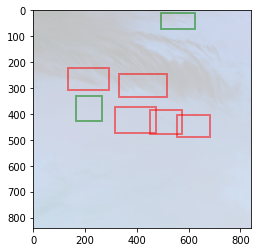

In [ ]:
#transform1=transforms.Compose([transforms.ColorJitter(hue=0.1)])
dataset=test_dataloader.dataset
im, box, turb, rois = dataset[0]

inp = im.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
imshow(inp, box,turb)
